In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt
import os
import string 
import shutil
import re



p = re.compile("[" + re.escape(string.punctuation) + "]")
print(p.sub("", "\"hello world!\", he's told me."))

hello world hes told me


#Load Data

In [2]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                  untar= True, cache_dir=".",
                                  cache_subdir="")

dataset_dir = os.path.join(os.path.dirname(dataset))
print(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
print(os.listdir(train_dir))

sample_file = os.path.join(train_dir, "csharp/0.txt")
with open(sample_file) as f:
    print(f.read())

6053888/6053168 [==============================] - 0s 0us/step
.
['python', 'csharp', 'javascript', 'java']
"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on fo

#Split train val test set with
##Staqndardize + tokenize + vectorize input data

In [3]:
batch_size = 32
seed = 42

print("----train----", str(train_dir))
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory( str(train_dir) ,
                                                                  batch_size=batch_size,
                                                                  validation_split=0.2,
                                                                  subset="training",
                                                                  seed=seed)

print("\n----Validation----")
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(str(train_dir),
                                                                batch_size=batch_size,
                                                                validation_split=0.2,
                                                                subset='validation',
                                                                seed=seed)

print("\n----test----")
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(str(test_dir),
                                                                batch_size=batch_size)



def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    
max_features = 10000
sequence_length = 250


vectorize_layer = TextVectorization(standardize=custom_standardization,
                                    max_tokens=max_features,
                                    output_mode='int',
                                    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return  vectorize_layer(text), label

train_ds =raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)



AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

----train---- ./train
Found 8000 files belonging to 4 classes.
Using 6400 files for training.

----Validation----
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.

----test----
Found 8000 files belonging to 4 classes.


#Model architecture

In [4]:
embedding_dim = 16
model = tf.keras.Sequential([layers.Embedding(max_features+1 , embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(4)])

model.summary()

model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


##training

In [5]:
print("----training-----")
epochs = 10
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs)

print("\n\n----------results------")
loss , accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)


----training-----
Epoch 1/10
200/200 [==============================] - 4s 19ms/step - loss: 1.3787 - accuracy: 0.3355 - val_loss: 1.3690 - val_accuracy: 0.4794
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 1.3525 - accuracy: 0.4439 - val_loss: 1.3344 - val_accuracy: 0.5213
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 1.3063 - accuracy: 0.5291 - val_loss: 1.2803 - val_accuracy: 0.5731
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 1.2429 - accuracy: 0.5856 - val_loss: 1.2109 - val_accuracy: 0.6231
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 1.1687 - accuracy: 0.6358 - val_loss: 1.1349 - val_accuracy: 0.6631
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 1.0893 - accuracy: 0.6750 - val_loss: 1.0614 - val_accuracy: 0.6913
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 1.0175 - accuracy: 0.6986 - val_loss: 0.9955 - val_accu

##Create a plot of accuracy and loss over time



-------plot the results------
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


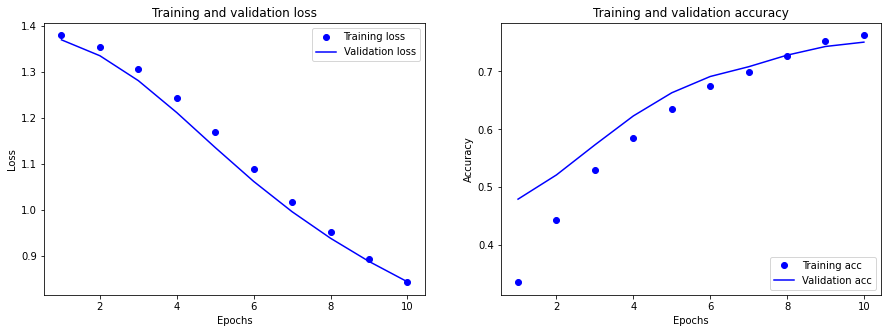

In [6]:
print("\n\n-------plot the results------")
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

#Export the model

In [7]:
export_model=tf.keras.Sequential([vectorize_layer,
                                  model,
                                  layers.Activation('sigmoid')
                                  ])

export_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                     optimizer='adam',
                     metrics=["accuracy"])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 13ms/step - loss: 1.1104 - accuracy: 0.7312
0.731249988079071
